## 時系列解析6_3 24時間後予想　データ追加 まだうまくいかない
https://qiita.com/mix_dvd/items/ecfa6f0038e39cdce57e

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.layers.recurrent import LSTM, GRU
from keras.layers import concatenate
from keras.layers import Input, merge
from keras.layers import Merge
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from utils import save_model_viz, save_weights, save_hist, plot_hist2

/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


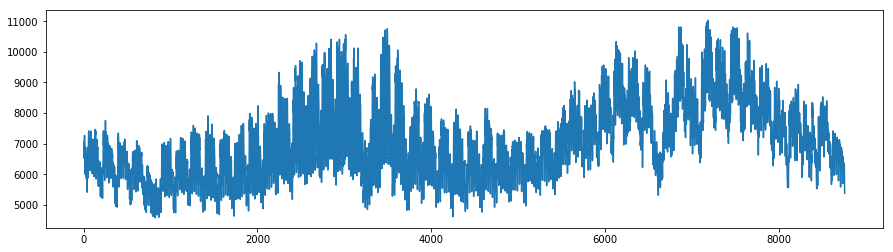

In [3]:
df_kw = pd.read_csv("data/juyo-2017.csv",encoding="Shift_JIS",skiprows=1)
df_kw["MW"] = df_kw["実績(万kW)"] * 10

df_kw["DATETIME"] = df_kw.index.map(lambda x: pd.to_datetime(df_kw.DATE[x] + " " + df_kw.TIME[x]))

# 可視化
df_kw["MW"].plot(figsize=(15,4))

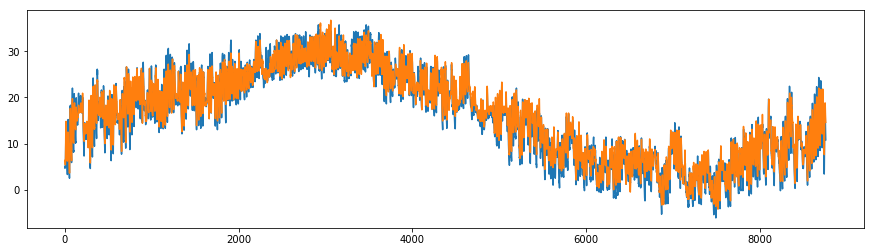

In [4]:
def read_temp(filename):
    df_temp = pd.read_csv(filename,encoding="Shift_JIS",skiprows=4)
    df_temp.columns = ["DATETIME","TEMP","品質情報","均質番号"]
    df_temp.DATETIME = df_temp.DATETIME.map(lambda _: pd.to_datetime(_))
    return df_temp

# 岡山
df_temp_okym = read_temp("data/data_okayama-2017.csv")
df_temp_okym.rename(columns = {'TEMP':'TEMP_okym'}, inplace=True)

# 広島
df_temp_hrsm = read_temp("data/data_hiroshima-2017.csv")
df_temp_hrsm.rename(columns = {'TEMP':'TEMP_hrsm'}, inplace=True)

# 可視化
df_temp_okym.TEMP_okym.plot(figsize=(15,4))
df_temp_hrsm.TEMP_hrsm.plot(figsize=(15,4))

In [5]:
len(df_temp_okym), len(df_temp_hrsm),len(df_kw)

(8760, 8760, 8760)

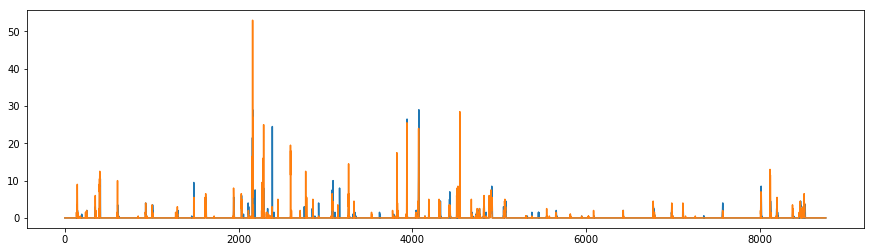

In [6]:
def read_rain(filename):
    df_rain = pd.read_csv(filename,encoding="Shift_JIS",skiprows=4)
    df_rain.columns = ["DATETIME","RAIN","現象なし情報", "品質情報","均質番号"]
    df_rain.DATETIME = df_rain.DATETIME.map(lambda _: pd.to_datetime(_))
    return df_rain

# 岡山
df_rain_okym = read_rain("data/data_okayama_rain-2017.csv")
df_rain_okym.rename(columns = {'RAIN':'RAIN_okym'}, inplace=True)

# 広島
df_rain_hrsm = read_rain("data/data_hiroshima_rain-2017.csv")
df_rain_hrsm.rename(columns = {'RAIN':'RAIN_hrsm'}, inplace=True)

# 可視化
df_rain_okym.RAIN_okym.plot(figsize=(15,4))
df_rain_hrsm.RAIN_hrsm.plot(figsize=(15,4))

In [7]:
len(df_rain_okym), len(df_rain_hrsm)

(8760, 8760)

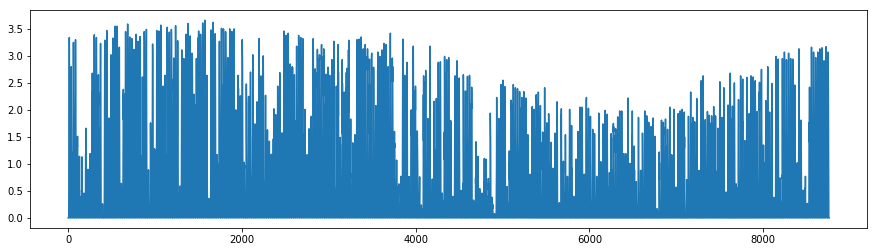

In [8]:
def read_sun(filename):
    df_sun = pd.read_csv(filename,encoding="Shift_JIS",skiprows=4)
    df_sun.columns = ["DATETIME","SUN","品質情報","均質番号"]
    df_sun.DATETIME = df_sun.DATETIME.map(lambda _: pd.to_datetime(_))
    return df_sun

# 広島
df_sun_hrsm = read_sun("data/data_hiroshima_sun-2017.csv")
df_sun_hrsm.rename(columns = {'SUN':'SUN_hrsm'}, inplace=True)

# 可視化
df_sun_hrsm.SUN_hrsm.plot(figsize=(15,4))

In [9]:
# データの複製
df = df_kw.copy()
# 岡山の気温を結合
df = df.merge(df_temp_okym,how="inner", on="DATETIME")
# 広島の気温を結合
df = df.merge(df_temp_hrsm,how="inner", on="DATETIME")

# 広島の降水量を結合
df = df.merge(df_rain_hrsm,how="inner", on="DATETIME")

# 岡山の降水量を結合
df = df.merge(df_rain_okym,how="inner", on="DATETIME")

# 広島の日射量を結合
df = df.merge(df_sun_hrsm,how="inner", on="DATETIME")

df = df.dropna()

In [10]:
df

,DATE,TIME,実績(万kW),MW,DATETIME,TEMP_okym,品質情報_x,均質番号_x,TEMP_hrsm,品質情報_y,...,現象なし情報_x,品質情報_x,均質番号_x,RAIN_okym,現象なし情報_y,品質情報_y,均質番号_y,SUN_hrsm,品質情報,均質番号
0,2017/4/1,1:00,660,6600,2017-04-01 01:00:00,4.7,8,1,6.3,8,...,1,8,1,0.0,0,8,1,0.00,8,1
1,2017/4/1,2:00,685,6850,2017-04-01 02:00:00,4.8,8,1,6.4,8,...,1,8,1,0.0,1,8,1,0.00,8,1
2,2017/4/1,3:00,706,7060,2017-04-01 03:00:00,4.9,8,1,6.2,8,...,1,8,1,0.0,1,8,1,0.00,8,1
3,2017/4/1,4:00,696,6960,2017-04-01 04:00:00,5.1,8,1,6.0,8,...,1,8,1,0.0,1,8,1,0.00,8,1
4,2017/4/1,5:00,667,6670,2017-04-01 05:00:00,5.0,8,1,5.8,8,...,1,8,1,0.0,1,8,1,0.00,8,1
5,2017/4/1,6:00,665,6650,2017-04-01 06:00:00,4.8,8,1,5.4,8,...,1,8,1,0.0,1,8,1,0.00,8,1
6,2017/4/1,7:00,662,6620,2017-04-01 07:00:00,5.1,8,1,5.5,8,...,1,8,1,0.0,1,8,1,0.12,8,1
7,2017/4/1,8:00,689,6890,2017-04-01 08:00:00,6.5,8,1,6.1,8,...,1,8,1,0.0,1,8,1,0.50,8,1
8,2017/4/1,9:00,727,7270,2017-04-01 09:00:00,8.1,8,1,8.1,8,...,1,8,1,0.0,1,8,1,1.14,8,1
9,2017/4/1,10:00,680,6800,2017-04-01 10:00:00,9.9,8,1,9.8,8,...,1,8,1,0.0,1,8,1,1.80,8,1


In [11]:
print(df.MW.mean(), df.TEMP_okym.mean(), df.TEMP_hrsm.mean(), df.RAIN_okym.mean(), df.RAIN_hrsm.mean(), df.SUN_hrsm.mean())
print(df.MW.std(), df.TEMP_okym.std(), df.TEMP_hrsm.std(), df.RAIN_okym.std(), df.RAIN_hrsm.std(), df.SUN_hrsm.std())

7105.1786733645395 15.711485329375469 16.354424021006995 0.15133006050919054 0.19831030939604977 0.6018666514442341
1243.3727995382856 9.511011061918847 9.128966280809285 1.017104348895309 1.2889970801163537 0.9140122183345718


In [12]:
df_MW = (df.MW - df.MW.mean())/df.MW.std()
df_TEMP_okym =  (df.TEMP_okym - df.TEMP_okym.mean())/df.TEMP_okym.std()
df_TEMP_hrsm =  (df.TEMP_hrsm - df.TEMP_hrsm.mean())/df.TEMP_hrsm.std()
df_RAIN_okym =  (df.RAIN_okym - df.RAIN_okym.mean())/df.RAIN_okym.std()
df_RAIN_hrsm =  (df.RAIN_hrsm - df.RAIN_hrsm.mean())/df.RAIN_hrsm.std()
df_SUN_hrsm =  (df.SUN_hrsm - df.SUN_hrsm.mean())/df.SUN_hrsm.std()

In [13]:
print(df_MW.mean(), df_TEMP_okym.mean(), df_TEMP_hrsm.mean(), df_RAIN_okym.mean(), df_RAIN_hrsm.mean(), df_SUN_hrsm.mean())
print(df_MW.std(), df_TEMP_okym.std(), df_TEMP_hrsm.std(), df_RAIN_okym.std(), df_RAIN_hrsm.std(), df_SUN_hrsm.std())

5.569240695967591e-16 2.852762361688383e-15 -2.8559565185807858e-15 1.8346375274608337e-15 -9.701871303899844e-16 -3.007831073679069e-16
0.9999999999999958 1.0000000000000044 0.9999999999999978 1.0000000000001976 0.9999999999999655 0.9999999999999338


In [14]:
def create_dataset(y, x1, x2, x3, x4, x5, steps_of_history, steps_in_future, predict_future):
    X, X_2, Y = [], [],[]
    for i in range(0, len(y)-steps_of_history - predict_future, steps_in_future):
        X.append([[y[i:i+steps_of_history]] ,[x1[i:i+steps_of_history]], [x2[i:i+steps_of_history]], [x3[i:i+steps_of_history]], [x4[i:i+steps_of_history]], [x5[i:i+steps_of_history] ]])    
        X_2.append([[x1[i+ predict_future:i+steps_of_history + predict_future]], [x2[i+ predict_future:i+steps_of_history+ predict_future]], [x3[i+ predict_future:i+steps_of_history + predict_future]], [x4[i+ predict_future:i+steps_of_history+ predict_future]],  [x5[i+ predict_future:i+steps_of_history+ predict_future]]])  
        Y.append(y[i + steps_of_history + predict_future])
    X = np.reshape(np.array(X), [-1, 6, steps_of_history]).transpose(0,2,1)
    X_2 = np.reshape(np.array(X_2), [-1, 5, steps_of_history]).transpose(0,2,1) 
    Y = np.reshape(np.array(Y), [-1, 1])
    return X, X_2, Y

def split_data(x, y, test_size=0.1):
    pos = round(len(x) * (1 - test_size))
    trainX, trainY = x[:pos], y[:pos]
    testX, testY   = x[pos:], y[pos:]
    return trainX, trainY, testX, testY

steps_of_history = 48
steps_in_future = 1
predict_future = 24

X, X_2, Y = create_dataset(df_MW, df_TEMP_okym, df_TEMP_hrsm,  df_RAIN_okym, df_RAIN_hrsm, df_SUN_hrsm ,steps_of_history, steps_in_future, predict_future)
trainX, trainY, testX, testY = split_data(X, Y, 0.33)
trainX_2, trainY_2, testX_2, testY_2 = split_data(X_2, Y, 0.33)

In [15]:
print(trainX.shape, trainY.shape,  testX.shape, testY.shape, trainX_2.shape,testX_2.shape)

(5820, 48, 6) (5820, 1) (2867, 48, 6) (2867, 1) (5820, 48, 5) (2867, 48, 5)


In [16]:
df_MW[0:49], df_TEMP_okym[0:49] , df_TEMP_hrsm[0:49], trainX[0],trainY[0], trainX_2[0]

(0    -0.406297
 1    -0.205231
 2    -0.036336
 3    -0.116762
 4    -0.349999
 5    -0.366084
 6    -0.390212
 7    -0.173060
 8     0.132560
 9    -0.245444
 10   -0.317828
 11   -0.671704
 12   -0.679747
 13   -0.880813
 14   -0.848642
 15   -0.792344
 16   -0.671704
 17   -0.285657
 18   -0.173060
 19   -0.317828
 20   -0.518894
 21   -0.736045
 22   -0.912983
 23   -0.937111
 24   -0.872770
 25   -0.559107
 26   -0.341956
 27   -0.430425
 28   -0.711917
 29   -0.824514
 30   -0.848642
 31   -1.001452
 32   -0.961239
 33   -1.041666
 34   -1.009495
 35   -1.081879
 36   -1.170348
 37   -1.290987
 38   -1.355329
 39   -0.969282
 40   -0.607363
 41   -0.317828
 42   -0.181103
 43   -0.309785
 44   -0.470638
 45   -0.744088
 46   -0.985367
 47   -0.921026
 48   -0.800386
 Name: MW, dtype: float64, 0    -1.157762
 1    -1.147248
 2    -1.136734
 3    -1.115705
 4    -1.126219
 5    -1.147248
 6    -1.115705
 7    -0.968507
 8    -0.800281
 9    -0.611027
 10   -0.505886
 11   -0.33766

In [17]:
CLS_LR = 0.0001
BATCHSIZE = 32
epochs = 6
np.random.seed(1234)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=20, min_lr=0.000001)

model_1 = Sequential()
model_1.add(LSTM(1024, return_sequences=False,
                     input_shape=(steps_of_history,6)))
# model_1.add(LSTM(64,return_sequences=False))

model_2 = Sequential()
model_2.add(LSTM(1024, return_sequences=False,
                     input_shape=(steps_of_history,5)))
# model_2.add(LSTM(64,return_sequences=False))

model = Sequential()
model.add(Merge([model_1, model_2], mode='concat', concat_axis=1))
model.add(Dense(256))
model.add(Dense(64))
model.add(Dense(1))
model.add(Activation("linear"))


model.compile(loss='mean_squared_error',optimizer=Adam(lr=CLS_LR))

model.summary()

hist = model.fit([trainX, trainX_2], trainY,
              batch_size=BATCHSIZE,
              epochs=epochs,
              verbose=1,
              validation_data=([testX, testX_2], testY),
              shuffle=True, callbacks=[reduce_lr])
                   
RUN_ID = 'LSTM2'
save_model_viz(RUN_ID, model)
save_weights(RUN_ID, model)
save_hist(RUN_ID, hist)
    

/Users/mitsuhiro/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:19: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 8,982,913
Trainable params: 8,982,913
Non-trainable params: 0
_________________________________________________________________
Train on 5820 samples, validate on 2867 samples
Epoch 1/6
5820/5820 [==============================] - 384s 66ms/step - loss: 0.2693

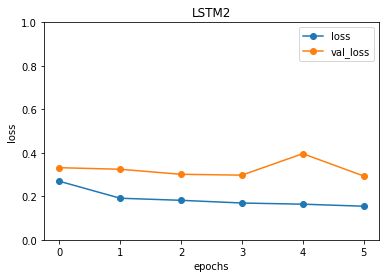

In [18]:
plot_hist2(RUN_ID)

KERAS REG RMSE : 673.51


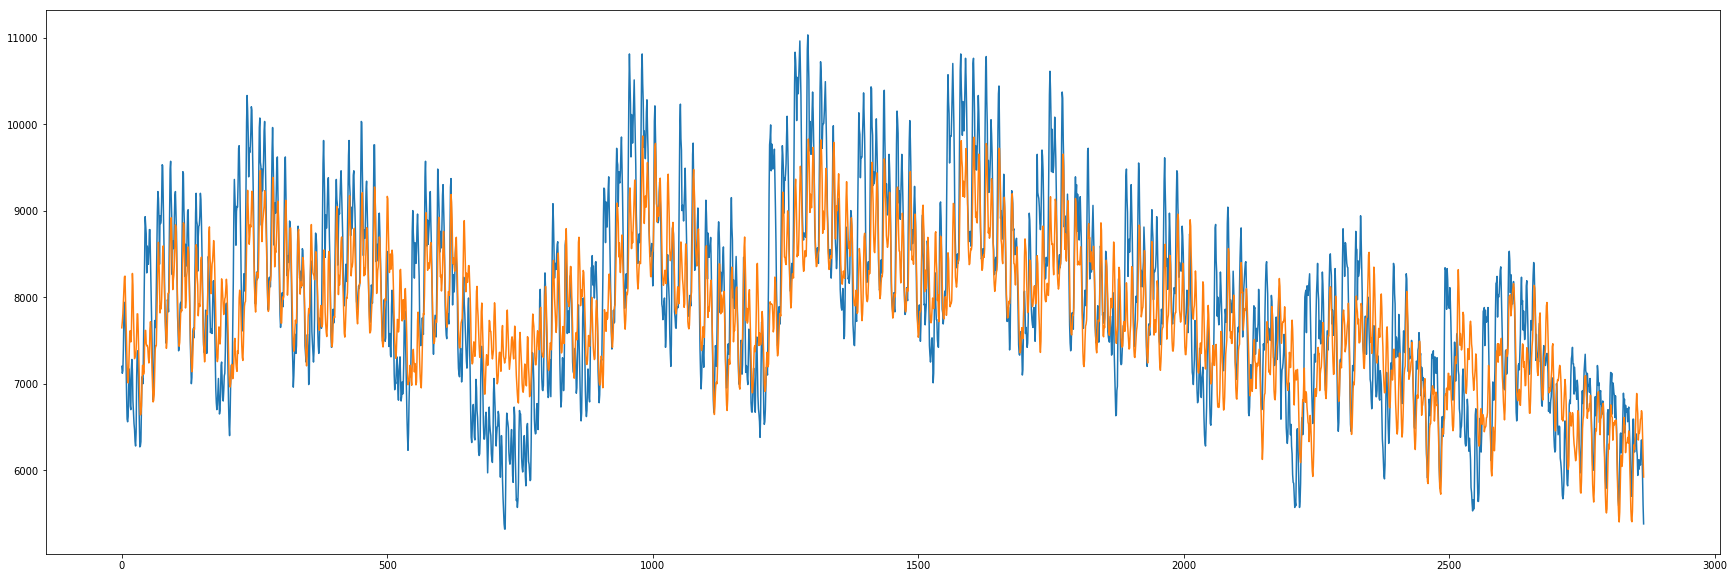

In [19]:
# 二乗平方根で誤差を算出
from sklearn.metrics import mean_squared_error

# 予測値の取得
y_pred = model.predict([testX, testX_2])
mse = mean_squared_error(testY*df.MW.std() + df.MW.mean(),y_pred*df.MW.std() + df.MW.mean() )
print("KERAS REG RMSE : %.2f" % (mse ** 0.5))

# 可視化
plt.figure(figsize=(30, 10))
plt.plot(testY*df.MW.std() + df.MW.mean(), label='truth')
plt.plot(y_pred*df.MW.std() + df.MW.mean() , label='pred')

# 2017年から2018年を予測

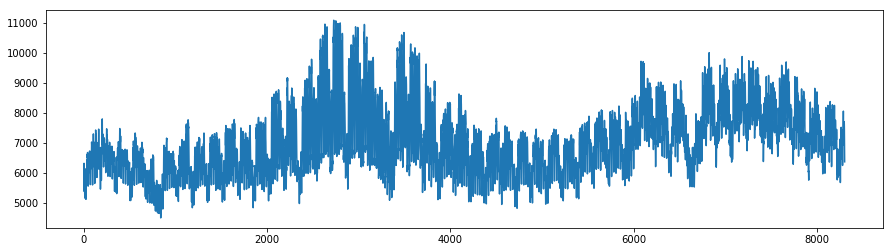

In [20]:
df_kw_18 = pd.read_csv("data/juyo-2018.csv",encoding="Shift_JIS",skiprows=1)
df_kw_18["MW"] = df_kw_18["実績(万kW)"] * 10

df_kw_18["DATETIME"] = df_kw_18.index.map(lambda x: pd.to_datetime(df_kw_18.DATE[x] + " " + df_kw_18.TIME[x]))

# 可視化
df_kw_18["MW"].plot(figsize=(15,4))

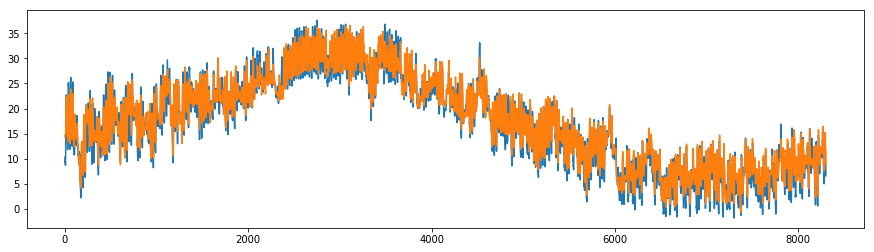

In [21]:
def read_temp(filename):
    df_temp = pd.read_csv(filename,encoding="Shift_JIS",skiprows=4)
    df_temp.columns = ["DATETIME","TEMP","品質情報","均質番号"]
    df_temp.DATETIME = df_temp.DATETIME.map(lambda _: pd.to_datetime(_))
    return df_temp

# 岡山
df_temp_okym_18 = read_temp("data/data_okayama-2018.csv")
df_temp_okym_18.rename(columns = {'TEMP':'TEMP_okym'}, inplace=True)

# 広島
df_temp_hrsm_18 = read_temp("data/data_hiroshima-2018.csv")
df_temp_hrsm_18.rename(columns = {'TEMP':'TEMP_hrsm'}, inplace=True)

# 可視化
df_temp_okym_18.TEMP_okym.plot(figsize=(15,4))
df_temp_hrsm_18.TEMP_hrsm.plot(figsize=(15,4))

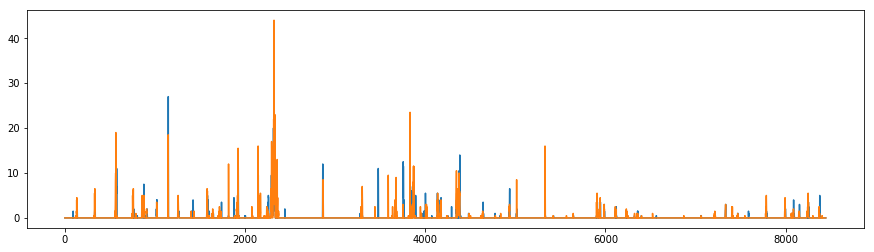

In [27]:
def read_rain(filename):
    df_rain = pd.read_csv(filename,encoding="Shift_JIS",skiprows=4)
    df_rain.columns = ["DATETIME","RAIN","現象なし情報", "品質情報","均質番号"]
    df_rain.DATETIME = df_rain.DATETIME.map(lambda _: pd.to_datetime(_))
    return df_rain

# 岡山
df_rain_okym_18 = read_rain("data/data_okayama_rain-2018.csv")
df_rain_okym_18.rename(columns = {'RAIN':'RAIN_okym'}, inplace=True)

# 広島
df_rain_hrsm_18 = read_rain("data/data_hiroshima_rain-2018.csv")
df_rain_hrsm_18.rename(columns = {'RAIN':'RAIN_hrsm'}, inplace=True)

# 可視化
df_rain_okym_18.RAIN_okym.plot(figsize=(15,4))
df_rain_hrsm_18.RAIN_hrsm.plot(figsize=(15,4))

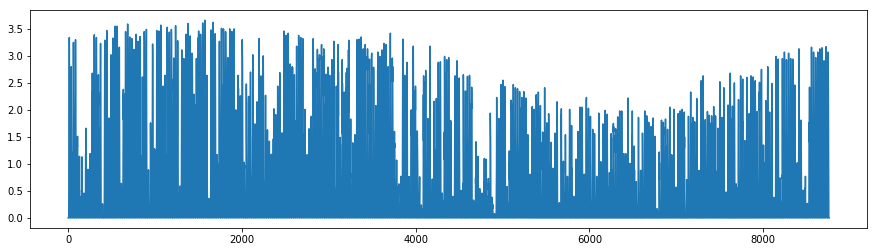

In [28]:
def read_sun(filename):
    df_sun = pd.read_csv(filename,encoding="Shift_JIS",skiprows=4)
    df_sun.columns = ["DATETIME","SUN","品質情報","均質番号"]
    df_sun.DATETIME = df_sun.DATETIME.map(lambda _: pd.to_datetime(_))
    return df_sun

# 広島
df_sun_hrsm_18 = read_sun("data/data_hiroshima_sun-2018.csv")
df_sun_hrsm_18.rename(columns = {'SUN':'SUN_hrsm'}, inplace=True)

# 可視化
df_sun_hrsm.SUN_hrsm.plot(figsize=(15,4))

In [30]:
# データの複製
df_18 = df_kw_18.copy()
# 岡山の気温を結合
df_18 = df_18.merge(df_temp_okym_18,how="inner", on="DATETIME")
# 広島の気温を結合
df_18 = df_18.merge(df_temp_hrsm_18,how="inner", on="DATETIME")

# 広島の降水量を結合
df_18 = df_18.merge(df_rain_hrsm_18,how="inner", on="DATETIME")

# 岡山の降水量を結合
df_18 = df_18.merge(df_rain_okym_18,how="inner", on="DATETIME")

# 広島の日射量を結合
df_18 = df_18.merge(df_sun_hrsm_18,how="inner", on="DATETIME")

df_18 = df_18.dropna()

In [31]:
df_MW_18 = (df_18.MW - df_18.MW.mean())/df_18.MW.std()
df_TEMP_okym_18 =  (df_18.TEMP_okym - df_18.TEMP_okym.mean())/df_18.TEMP_okym.std()
df_TEMP_hrsm_18 =  (df_18.TEMP_hrsm - df_18.TEMP_hrsm.mean())/df_18.TEMP_hrsm.std()
df_RAIN_okym_18 =  (df_18.RAIN_okym - df_18.RAIN_okym.mean())/df_18.RAIN_okym.std()
df_RAIN_hrsm_18 =  (df_18.RAIN_hrsm - df_18.RAIN_hrsm.mean())/df_18.RAIN_hrsm.std()
df_SUN_hrsm_18 =  (df_18.SUN_hrsm - df_18.SUN_hrsm.mean())/df_18.SUN_hrsm.std()

In [32]:
def create_dataset(y, x1, x2, x3, x4, x5, steps_of_history, steps_in_future, predict_future):
    X, X_2, Y = [], [],[]
    for i in range(0, len(y)-steps_of_history - predict_future, steps_in_future):
        X.append([[y[i:i+steps_of_history]] ,[x1[i:i+steps_of_history]], [x2[i:i+steps_of_history]], [x3[i:i+steps_of_history]], [x4[i:i+steps_of_history]], [x5[i:i+steps_of_history] ]])    
        X_2.append([[x1[i+ predict_future:i+steps_of_history + predict_future]], [x2[i+ predict_future:i+steps_of_history+ predict_future]], [x3[i+ predict_future:i+steps_of_history + predict_future]], [x4[i+ predict_future:i+steps_of_history+ predict_future]],  [x5[i+ predict_future:i+steps_of_history+ predict_future]]])  
        Y.append(y[i + steps_of_history + predict_future])
    X = np.reshape(np.array(X), [-1, 6, steps_of_history]).transpose(0,2,1)
    X_2 = np.reshape(np.array(X_2), [-1, 5, steps_of_history]).transpose(0,2,1) 
    Y = np.reshape(np.array(Y), [-1, 1])
    return X, X_2, Y

def split_data(x, y, test_size=0.1):
    pos = round(len(x) * (1 - test_size))
    trainX, trainY = x[:pos], y[:pos]
    testX, testY   = x[pos:], y[pos:]
    return trainX, trainY, testX, testY

steps_of_history = 48
steps_in_future = 1
predict_future = 24

X_18, X_2_18, Y_18 = create_dataset(df_MW_18, df_TEMP_okym_18, df_TEMP_hrsm_18,  df_RAIN_okym_18, df_RAIN_hrsm_18, df_SUN_hrsm_18 ,steps_of_history, steps_in_future, predict_future)
trainX_18, trainY_18, testX_18, testY_18 = split_data(X, Y, 0.33)
trainX_2_18, trainY_2_18, testX_2_18, testY_2_18 = split_data(X_2, Y, 0.33)

KERAS REG RMSE : 543.46


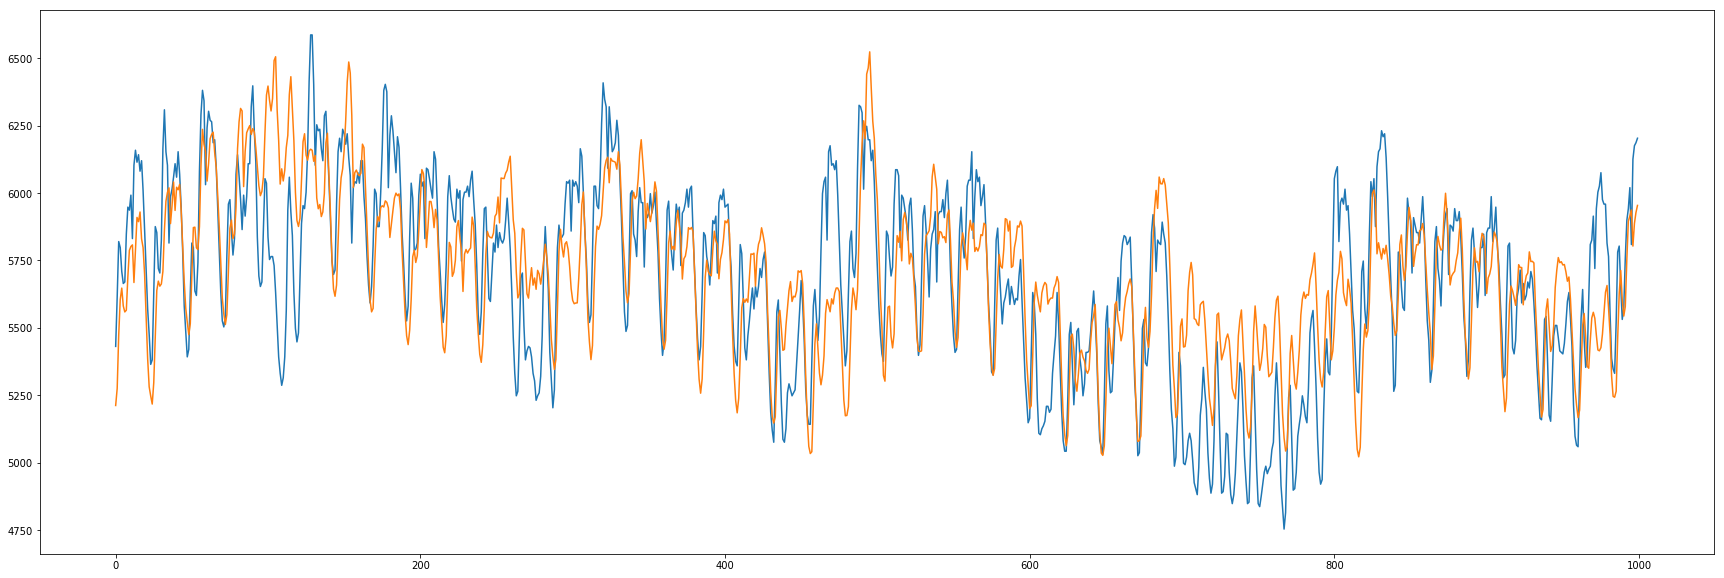

In [34]:
# 二乗平方根で誤差を算出
from sklearn.metrics import mean_squared_error

# 予測値の取得
y_pred_18 = model.predict([X_18, X_2_18])
mse = mean_squared_error(Y_18*df_18.MW.std() + df_18.MW.mean(),y_pred_18*df_18.MW.std() + df_18.MW.mean() )
print("KERAS REG RMSE : %.2f" % (mse ** 0.5))

# 可視化
plt.figure(figsize=(30, 10))
plt.plot(Y_18[0:1000]*df_18[0:1000].MW.std() + df_18[0:1000].MW.mean(), label='truth')
plt.plot(y_pred_18[0:1000]*df_18[0:1000].MW.std() + df_18[0:1000].MW.mean() , label='pred')

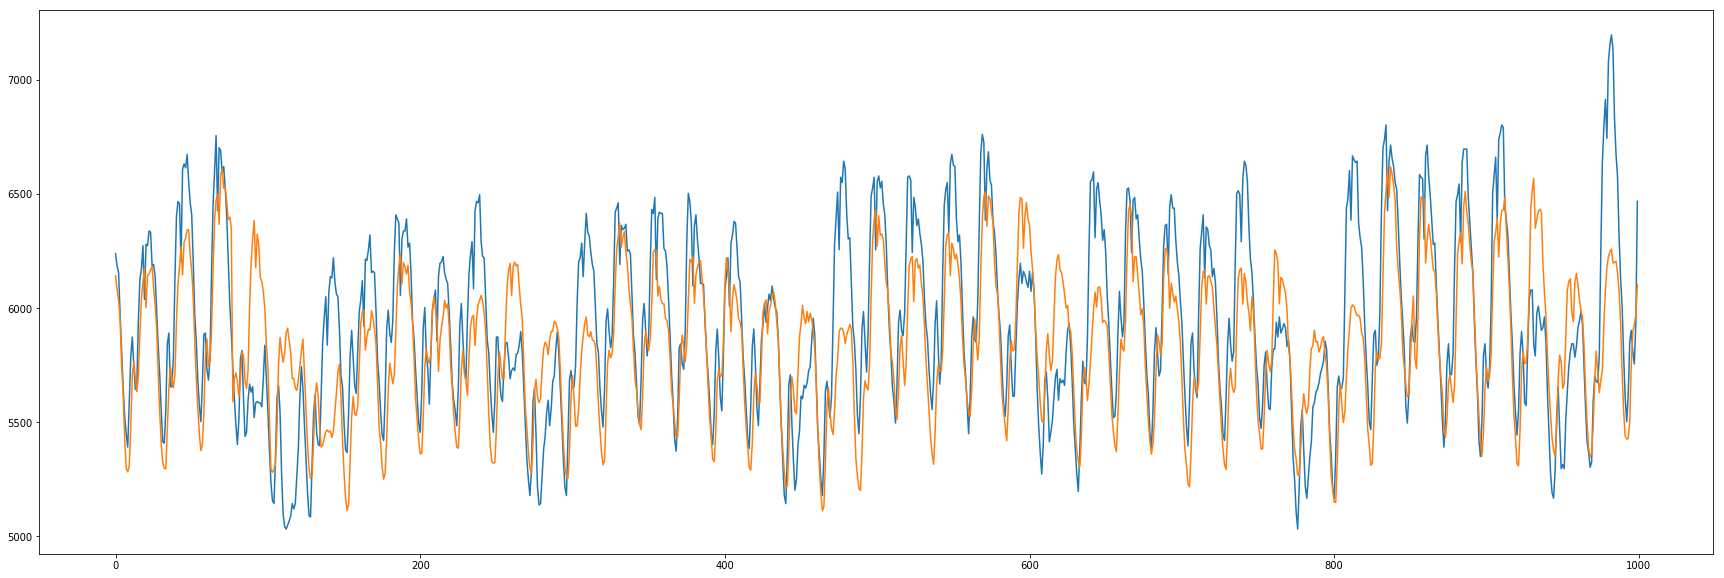

In [35]:
# 可視化
plt.figure(figsize=(30, 10))
plt.plot(Y_18[1000:2000]*df_18[1000:2000].MW.std() + df_18[1000:2000].MW.mean(), label='truth')
plt.plot(y_pred_18[1000:2000]*df_18[1000:2000].MW.std() + df_18[1000:2000].MW.mean() , label='pred')